# Data Pre-Processing

In [1]:
!pip install wfdb

  Could not fetch URL https://pypi.python.org/simple/wfdb/: There was a problem confirming the ssl certificate: [SSL: TLSV1_ALERT_PROTOCOL_VERSION] tlsv1 alert protocol version (_ssl.c:661) - skipping
  Could not find a version that satisfies the requirement wfdb (from versions: )
No matching distribution found for wfdb


In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import wfdb
from wfdb import processing
from matplotlib import pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
import umap
import sklearn.utils as slu
from sklearn.model_selection import LeaveOneOut

### Set Path to where the mit-bih arrhythmia database is downloaded to

In [1]:
def get_data(path):
    file_path = glob(path)
    files = [i[:-4] for i in file_path]
    files.sort()
    return files

In [5]:
path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/mit-bih-arrhythmia-database-1.0.0/*.atr'

file_list = get_data(path)


## Histogram

(112647,)


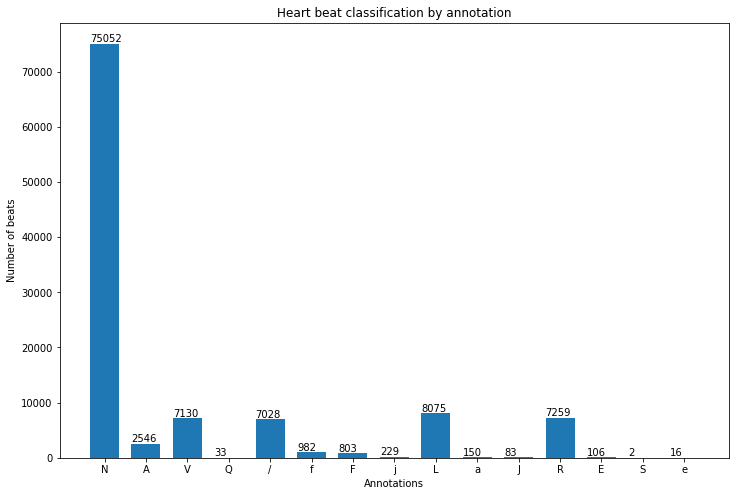

In [6]:
ann_list = []
for i in range(len(file_list)): #going through each of the 48 files...
    data_file = file_list[i] #one file of the 48
    record = wfdb.rdsamp(data_file)  #returns an array of the sample
    ann_ref = wfdb.rdann(data_file, 'atr') #reading annotations in the file
    ann_list.extend(ann_ref.symbol)
    
ann_array = np.array(ann_list)
print(ann_array.shape)



actual_beats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

ann_dict = {}

for i in ann_array:
    ann_dict[i] = ann_dict.get(i,0)+1

ann_dict = {k:v for k,v in ann_dict.items() if k in actual_beats}


plt.figure(figsize=(12,8))

xlocs, xlabs = plt.xticks()

bars = plt.bar(list(ann_dict.keys()), ann_dict.values(), width=.7)
plt.title("Heart beat classification by annotation")
xlocs = [i for i in ann_dict.keys()]
ylabs = [i for i in ann_dict.values()]

plt.xlabel("Annotations")
plt.ylabel("Number of beats")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 300, yval)

## Load files, split into individual beats, centre and standardise them and save to separate files

In [7]:
for file in file_list:
    
    path = file.split('/')
    fn = path[-1]
    record = wfdb.rdsamp(file)
    ecg_val = record[0].T # 2, 650000
    ann_ref = wfdb.rdann(file,'atr')
    ann_list = np.array(ann_ref.symbol)
    ann_number = np.zeros_like(ann_list, dtype='float')
    
    # encode the annotations as numbers
    for annid, anno in enumerate(ann_list):
        if anno == 'N':
            ann_number[annid] = 1.0
        elif anno == 'L':
            ann_number[annid] = 2.0
        elif anno == 'R':
            ann_number[annid] = 3.0
        elif anno == 'A':
            ann_number[annid] = 4.0
        elif anno == 'V':
            ann_number[annid] = 5.0
        elif anno == 'F':
            ann_number[annid] = 6.0
        elif anno == 'f':
            ann_number[annid] = 7.0
        elif anno == '/':
            ann_number[annid] = 8.0
            
    all_ann_numbers = np.zeros_like(ecg_val[0], dtype='float')
    all_ann_numbers[ann_ref.sample] = ann_number
    
    for ch_id, channel in enumerate(ecg_val): #enumerates the 2 channels - so 0 and 1
        channel_name = record[1].get('sig_name')[ch_id]
        print("ECG channel: ", channel_name)
        
        # ecg_output = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        
        # center the r peak
        rpeak_indices = ann_ref.sample[1:-1] #2272
        all_beats = []
        for i,peak in enumerate(rpeak_indices):
            start,end = peak-256//2, peak+256//2
            if start < 0:
                start = 0
            diff = 256 - len(channel[start:end])
            if diff > 0:
                padding = np.zeros(diff, dtype='float')
                padded_channel = np.append(padding, channel[start:end])
                all_beats.append(padded_channel)
            else:
                all_beats.append(channel[start:end])

#         for i, i_val in enumerate(rpeak_indices):
            # obtain annotation for each beat
            if peak < 10:
                from_i = 0
            else:
                from_i = peak - 10
            to_i = peak + 10
            anno = all_ann_numbers[from_i:to_i].max()

            
            # standardise the data
            all_beats[i] = (all_beats[i]-np.mean(all_beats[i]))/np.std(all_beats[i])
            
            # append the annotation to each beat
            all_beats[i] = np.append(all_beats[i], anno)
            
            # append file number
            all_beats[i] = np.append(all_beats[i], fn)

            # append channel number (0 or 1)
            all_beats[i] = np.append(all_beats[i], ch_id)
        
        # save to file per patient
        all_beats = np.array(all_beats, dtype='float64')
        savedata = all_beats 
        outfn = './data_ecg/'+fn+'_'+channel_name+'.csv'
        print('    Generating ', outfn)
        if not os.path.exists('./data_ecg/'):
            os.makedirs('./data_ecg/')
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')

ECG channel:  MLII
    Generating  ./data_ecg/100_MLII.csv
ECG channel:  V5
    Generating  ./data_ecg/100_V5.csv
ECG channel:  MLII
    Generating  ./data_ecg/101_MLII.csv
ECG channel:  V1
    Generating  ./data_ecg/101_V1.csv
ECG channel:  V5
    Generating  ./data_ecg/102_V5.csv
ECG channel:  V2
    Generating  ./data_ecg/102_V2.csv
ECG channel:  MLII
    Generating  ./data_ecg/103_MLII.csv
ECG channel:  V2
    Generating  ./data_ecg/103_V2.csv
ECG channel:  V5
    Generating  ./data_ecg/104_V5.csv
ECG channel:  V2
    Generating  ./data_ecg/104_V2.csv
ECG channel:  MLII
    Generating  ./data_ecg/105_MLII.csv
ECG channel:  V1
    Generating  ./data_ecg/105_V1.csv
ECG channel:  MLII
    Generating  ./data_ecg/106_MLII.csv
ECG channel:  V1
    Generating  ./data_ecg/106_V1.csv
ECG channel:  MLII
    Generating  ./data_ecg/107_MLII.csv
ECG channel:  V1
    Generating  ./data_ecg/107_V1.csv
ECG channel:  MLII
    Generating  ./data_ecg/108_MLII.csv
ECG channel:  V1
    Generating  ./da

In [8]:
all_data = np.empty(shape=[0,259])
print(all_data.shape)
csv_files = glob('./data_ecg/*.csv')

for file in csv_files:
    heartbeat = np.loadtxt(file, delimiter=',')
    all_data = np.append(all_data, heartbeat, axis=0)

print("loaded all data")
print(all_data.shape)

(0, 259)
loaded all data
(225102, 259)


## Delete beats that have not been annotated

In [9]:
# beats with no annotation
no_anno = np.where(all_data[:,-3]==0.0)[0]
# delete
all_data = np.delete(all_data, no_anno,0)



In [10]:
print(all_data.shape)

(217656, 259)


In [13]:
outfn = './preprocessed_data/unsampled_all_data.csv'
print('    Generating ', outfn)
if not os.path.exists('./preprocessed_data/'):
    os.makedirs('./preprocessed_data/')
with open(outfn, "wb") as fin:
    np.savetxt(fin, all_data, delimiter=",", fmt='%f')

    Generating  ./preprocessed_data/unsampled_all_data.csv


In [16]:
all_data_file = np.loadtxt('./preprocessed_data/unsampled_all_data.csv', delimiter=',')
print(all_data_file.shape)

(217656, 259)


## Visualise the heartbeats

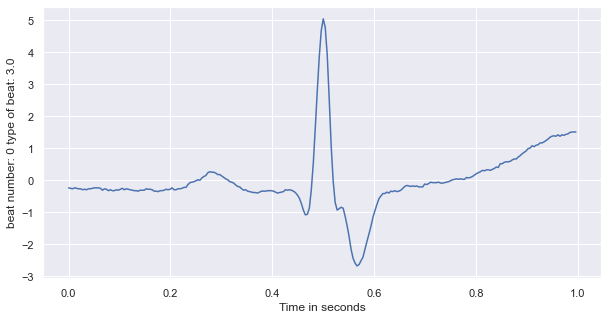

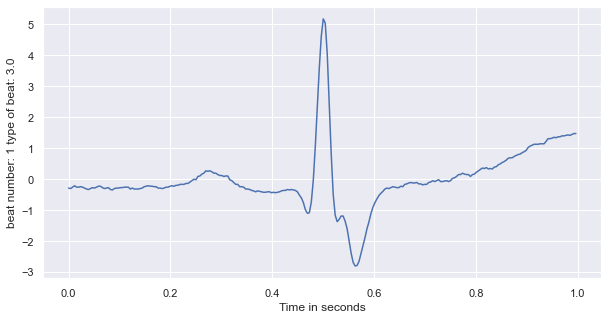

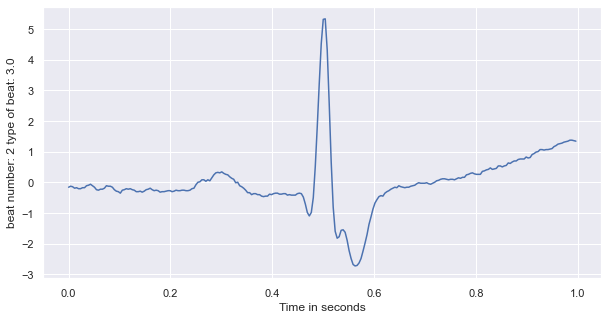

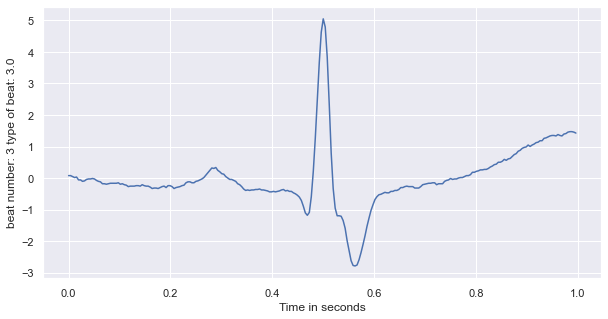

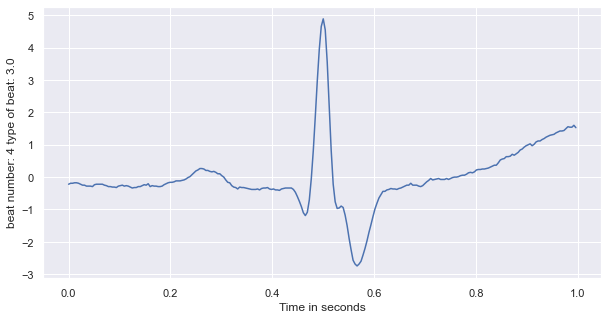

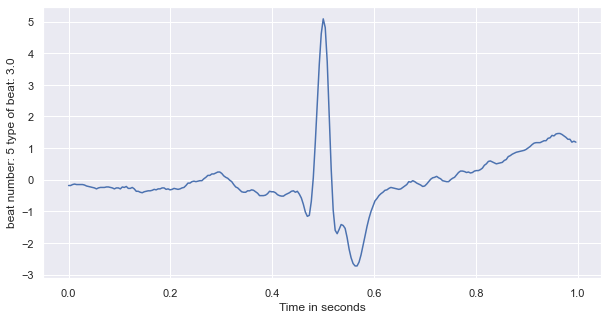

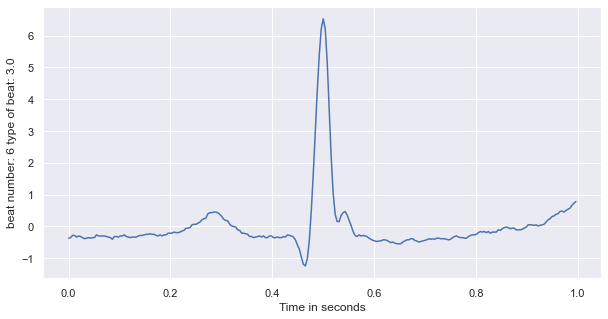

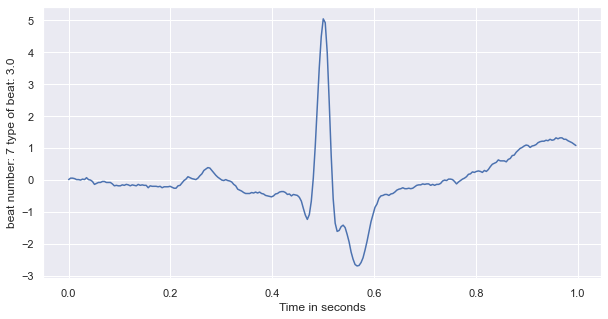

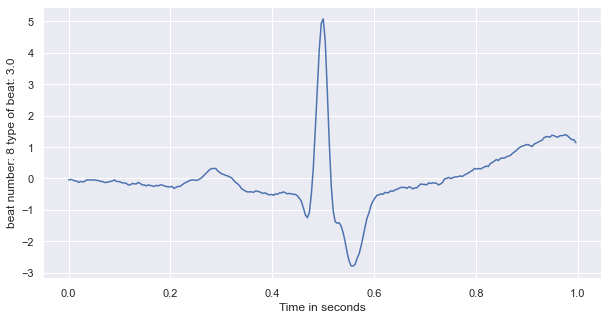

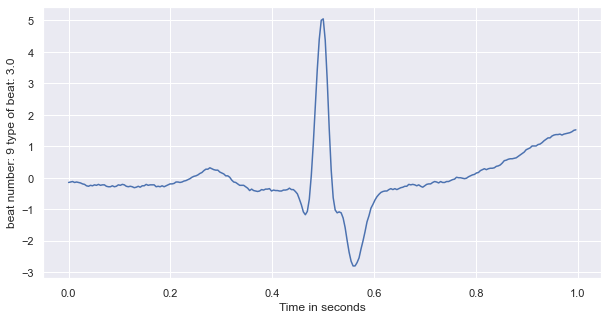

In [17]:
ann_value = all_data_file[:,-3]
a = all_data_file[ann_value==3.0]

for i in range(10):
    data = a[i]
    time_value = np.arange(256, dtype = 'float') / 256
    current_beat = data[:-3]
    ann_num = data[-3]
    plt.figure(figsize=(10,5))
    plt.plot(time_value, current_beat)
    plt.xlabel('Time in seconds')
    plt.ylabel('beat number: ' + str(i) + ' type of beat: ' + str(ann_num))

## Histogram of Unsampled beats after pre-processing

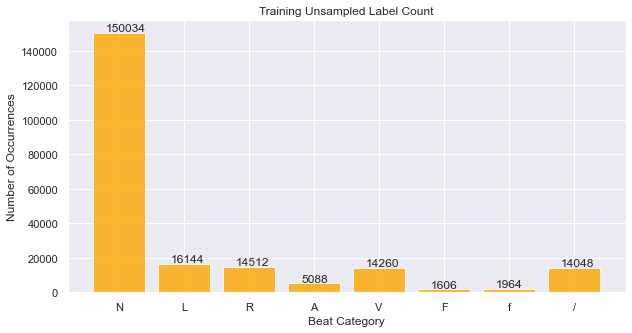

In [18]:
import seaborn as sns
sns.set()
feature_names = ['N','L','R','A','V','F','f','/']

dftrain = pd.DataFrame(all_data_file)
countstrain = dftrain[256].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstrain.index, countstrain.values, alpha=0.8, color='orange')
plt.title('Training Unsampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+1000, yval)
plt.show()

## Test Train Split - Hold Out - 75/25 split

In [19]:
shuffled_all = all_data_file
np.random.shuffle(shuffled_all)

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(shuffled_all, test_size=0.25)

print(train.shape)
print(test.shape)


(163242, 259)
(54414, 259)


In [22]:
if not os.path.exists('./train_test_unsampled/'):
    os.makedirs('./train_test_unsampled/')
train_file = './train_test_unsampled/train.csv'
test_file = './train_test_unsampled/test.csv'

with open(train_file, 'wb') as f:
    np.savetxt(f, train, delimiter=",", fmt='%f')

with open(test_file, 'wb') as f:
    np.savetxt(f, test, delimiter=",", fmt='%f')


In [24]:
# to load from files: change path as necessary
path = '/content/drive/MyDrive/ecg'
train = np.loadtxt('./train_test_unsampled/train.csv', delimiter=',')
test = np.loadtxt('./train_test_unsampled/test.csv', delimiter=',')


In [25]:
print(train.shape)
print(test.shape)


(163242, 259)
(54414, 259)


In [26]:
seed=42
np.random.seed(seed)
def downsample(arr,n,seed):
    downsampled = slu.resample(arr,replace=False,n_samples=n,random_state=seed)
    return downsampled

def upsample(arr,n,seed):
    upsampled = slu.resample(arr,replace=True,n_samples=n,random_state=seed)
    return upsampled

## Naive Resampling

In [35]:
anno = train[:,-3]
normal = train[anno == 1.0]
lbbb = train[anno == 2.0]
rbbb = train[anno == 3.0]
apb = train[anno == 4.0]
pvc = train[anno == 5.0]
fvn = train[anno == 6.0]
fpn = train[anno == 7.0]
paced = train[anno == 8.0]

abnormal = [lbbb,rbbb,apb,pvc,fvn,fpn,paced]
list_len = [len(i) for i in abnormal]
print(list_len)

all_classes = [normal,lbbb,rbbb,apb,pvc,fvn,fpn,paced]

num_of_vals = np.mean(list_len, dtype=int)
print(num_of_vals)

sampled_data = []
for i in all_classes:
    if i.shape[0] > num_of_vals:
        i = downsample(i, num_of_vals,seed)
    elif i.shape[0] < num_of_vals:
        i = upsample(i, num_of_vals,seed)
    sampled_data.append(i)


sampled_data = np.concatenate(sampled_data)
# print(sampled_data[0])
np.random.shuffle(sampled_data)
# print(sampled_data.shape)

[12122, 10806, 3817, 10764, 1199, 1443, 10556]
7243
[ 3.823560e-01  4.631840e-01  5.440120e-01  4.631840e-01  3.015270e-01
  3.823560e-01  3.823560e-01  6.248410e-01  1.109810e+00  1.109810e+00
  1.109810e+00  9.481540e-01  9.481540e-01  7.056690e-01  7.864970e-01
  8.673250e-01  8.673250e-01  8.673250e-01  8.673250e-01  8.673250e-01
  9.481540e-01  8.673250e-01  9.481540e-01  1.028982e+00  7.864970e-01
  8.673250e-01  7.864970e-01  9.481540e-01  1.271467e+00  1.109810e+00
  9.481540e-01  7.864970e-01  5.440120e-01  3.823560e-01  5.440120e-01
  6.248410e-01  1.028982e+00  1.109810e+00  1.352295e+00  1.271467e+00
  1.271467e+00  1.109810e+00  7.864970e-01  8.673250e-01  8.673250e-01
  1.109810e+00  1.433123e+00  1.352295e+00  1.190639e+00  1.271467e+00
  1.028982e+00  1.352295e+00  1.271467e+00  1.109810e+00  7.056690e-01
  9.481540e-01  1.271467e+00  1.271467e+00  1.109810e+00  1.109810e+00
  1.109810e+00  1.109810e+00  1.513952e+00  1.513952e+00  1.271467e+00
  9.481540e-01  9.481540e

In [36]:
if not os.path.exists('./train_test_sampled/'):
    os.makedirs('./train_test_sampled/')
train_samp_file = './train_test_sampled/train.csv'
test_samp_file = './train_test_sampled/test.csv'

with open(train_samp_file, 'wb') as f:
    np.savetxt(f, sampled_data, delimiter=",", fmt='%f')

with open(test_samp_file, 'wb') as f:
    np.savetxt(f, test, delimiter=",", fmt='%f')

In [37]:
train_samp = np.loadtxt('./train_test_sampled/train.csv', delimiter=',')
test_samp = np.loadtxt('./train_test_sampled/test.csv', delimiter=',')

print(train_samp.shape)
print(test_samp.shape)

(57944, 259)
(54414, 259)


(57944, 257)


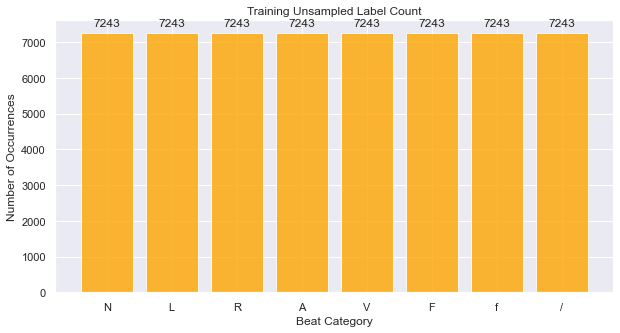

In [38]:
import seaborn as sns
sns.set()
feature_names = ['N','L','R','A','V','F','f','/']

dftrain = pd.DataFrame(train_samp[:,:-2])
print(dftrain.shape)
countstrain = dftrain[256].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstrain.index, countstrain.values, alpha=0.8, color='orange')
plt.title('Training Sampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+200, yval)
plt.show()

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
label_count = Counter(train[:,-3])
print(label_count)
classes, counts = np.unique(train[:,-3], return_counts=True)
imbalanced = counts[1:]
imb_max = np.max(imbalanced)
print(imb_max)
normal_count = counts[0]
print(normal_count)

Counter({1.0: 78355, 2.0: 12093, 3.0: 8340, 8.0: 8230, 5.0: 7089, 6.0: 1177, 4.0: 1173, 7.0: 1056})
12093
78355


In [ ]:
samp_strat = {1:normal_count,2:imb_max,3:imb_max,4:imb_max,5:imb_max,6:imb_max,7:imb_max, 8:imb_max}
sm = SMOTE(random_state=42, sampling_strategy=samp_strat)
train_bal = sm.fit_resample(train, train[:,-3])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print(Counter(train_bal[1]))

Counter({1.0: 78355, 2.0: 12093, 8.0: 12093, 3.0: 12093, 5.0: 12093, 7.0: 12093, 6.0: 12093, 4.0: 12093})


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
train_up = rus.fit_resample(train_bal[0], train_bal[1])

print(Counter(train_up[1]))

Counter({1.0: 12093, 2.0: 12093, 3.0: 12093, 4.0: 12093, 5.0: 12093, 6.0: 12093, 7.0: 12093, 8.0: 12093})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(96744, 257)


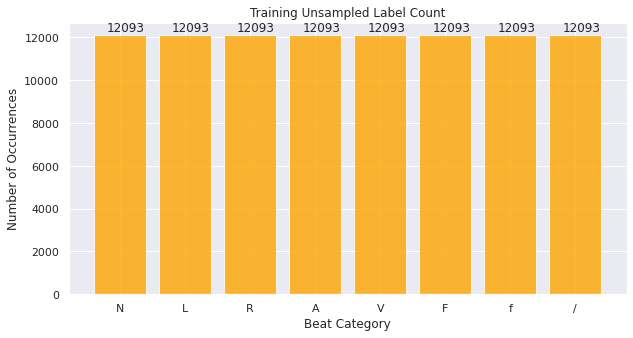

In [ ]:
import seaborn as sns
sns.set()
feature_names = ['N','L','R','A','V','F','f','/']

dftrain = pd.DataFrame(train_up[0][:,:-2])
print(dftrain.shape)
countstrain = dftrain[256].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstrain.index, countstrain.values, alpha=0.8, color='orange')
plt.title('Training Sampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+200, yval)
plt.show()

In [ ]:
X_train = train_up[0][:,:-3]
y_train = train_up[0][:,-3]
X_test = test[:,:-3]
y_test = test[:,-3]